In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataproc import DataProc
import time
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn_extra.cluster import KMedoids, CLARA, CommonNNClustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, TensorDataset
import xgboost as xgb

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [3]:
infer_target = "water"
pred_target = "hotwater"
method = "tae"
clustering = "kmedoids"

dp = DataProc(infer_target)
train_date = '2021-12-18'

# 각 자원별 데이터 불러와 딕셔너리에 저장
train, test, total = {}, {}, {}
for i in dp.energy_list:
    train[i], test[i], total[i] = dp.load_customized_data(i, '1H')

dp.elec_total = total["elec"]         # 전체 단지 전기 사용량
dp.region_A = train["elec"].columns   # A단지 목록
dp.region_B = test["elec"].columns    # B단지 목록

# 유추 대상(=target) 사용량 저장
dp.target_total = total[dp.target]
dp.target_train = total[dp.target][:train_date]
dp.target_test = total[dp.target][train_date:]
train_size = len(dp.target_train)

# 유추 대상 제외한 사용량 저장
except_target = dp.energy_list.copy()
except_target.remove(dp.target)
energy_total = [total[i] for i in except_target]
dp.original_total = energy_total
dp.target, except_target

# 데이터 정규화한 뒤 저장: 훈련용 데이터 기준으로 정규화
# 코드 상으론 사용하지 않는 변수
dp.energy_total = []
dp.energy_train = []
dp.energy_test = []
dp.energy_cluster = []
for i in range(3):
    total = energy_total[i]
    train = total[:train_date]
    test = total[train_date:]

    dp.energy_total.append(total)
    dp.energy_train.append(train)
    dp.energy_test.append(test)

start = train_size
end = start + (len(dp.target_total) - train_size)*7//10
    
"""
method = gae or rae or tae
"""
n_clusters = 5
path = '/root/workspace/AMI/InferProj'
if method == 'gae':
    repr_file_name =  f'h_r_0_0'
else:
    repr_file_name =  f'arr_0_0'
arr_hidden = pd.read_csv(f'{path}/hidden/{method}_{infer_target}/{repr_file_name}.csv',index_col=0)

pca = PCA(n_components=28*2, random_state=42)
arr_hidden_pca = pca.fit_transform(arr_hidden)

if clustering == 'kmedoids':
    clusters = KMedoids(n_clusters=n_clusters, random_state=42).fit(arr_hidden_pca)
elif clustering == 'kmeans':
    clusters = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42).fit(arr_hidden_pca)
elif clustering == 'agglomerative':
    clusters = AgglomerativeClustering(n_clusters=n_clusters).fit(arr_hidden_pca)
elif clustering == 'gmm':
    gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(arr_hidden_pca)
    clusters = type('GMMClusters', (object,), {'labels_': gmm.predict(arr_hidden_pca)})()

labels = clusters.labels_

#각 클러스터의 중심으로 water 사용량 할당
target_test_result = pd.DataFrame(columns=dp.region_B,index=dp.target_total.loc[train_date:].index)
for j in range(n_clusters):
    for k in list(set(dp.region_B) & set(dp.target_total.columns[labels==j])):
        target_test_result[k] = dp.target_total[list(set(dp.region_A) & set(dp.target_train.columns[labels==j]))].loc[train_date:].mean(axis=1)

#클러스터 구성요소가 B단지 1가구인 클러스터는 A단지 평균으로 할당
for k in set(target_test_result.columns) - set(target_test_result.dropna(axis=1).columns):
    target_test_result[k] = dp.target_total[dp.region_A].loc[train_date:].mean(axis=1)

inferred_target_B = target_test_result.sum(axis=1)
target_B = dp.target_test[dp.region_B].sum(axis=1)
target_A = dp.target_test[dp.region_A].sum(axis=1)*len(dp.region_B)/len(dp.region_A)
data = {
    'target': target_B,
    'energy_0': dp.energy_test[0].sum(axis=1), 
    'energy_1': dp.energy_test[1].sum(axis=1), 
    'energy_2': dp.energy_test[2].sum(axis=1),
    'inferred': inferred_target_B,
    'referred': target_A
    }

df = pd.DataFrame(data)

# 데이터 나누기
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=False)

# 스케일러 생성
energy_scalers = {
    'energy_0': MinMaxScaler(),
    'energy_1': MinMaxScaler(),
    'energy_2': MinMaxScaler(),
    'target': MinMaxScaler(),
    'inferred': MinMaxScaler(),
    'referred': MinMaxScaler()
}

# 각 energy 컬럼에 대해 스케일링
for col, scaler in energy_scalers.items():
    train_df[col] = scaler.fit_transform(train_df[[col]])
    test_df[col] = scaler.transform(test_df[[col]])

# 결과 출력
df = pd.concat([train_df, test_df])
df.columns = [dp.target, except_target[0], except_target[1], except_target[2], 'inferred', 'referred']
df

,water,elec,gas,hotwater,inferred,referred
time,,,,,,
2021-12-18 00:00:00,0.315789,0.268310,0.091398,0.526316,0.364982,0.376812
2021-12-18 01:00:00,0.236842,0.213581,0.080645,0.321053,0.268559,0.265700
2021-12-18 02:00:00,0.092105,0.156439,0.048387,0.189474,0.154920,0.159420
2021-12-18 03:00:00,0.118421,0.122334,0.048387,0.121053,0.092568,0.096618
2021-12-18 04:00:00,0.078947,0.099497,0.016129,0.057895,0.069247,0.072464
...,...,...,...,...,...,...
2022-02-17 19:00:00,0.394737,0.264386,0.682796,0.615789,0.660567,0.628019
2022-02-17 20:00:00,0.460526,0.320423,0.731183,0.700000,0.694450,0.690821
2022-02-17 21:00:00,0.631579,0.353421,0.413978,0.773684,0.607605,0.618357


In [80]:
# 하이퍼파라미터 설정
num_epochs = 100
hidden_size = 64
num_layers = 2
sequence_length = 72
pred_length = 16

def doit():
    columns = ['4종유추', '4종평균', '4종실제', '3종실제']
    df_mae = pd.DataFrame(columns=columns, index=except_target)
    for target in [1, 2, 3]:
        maes = []
        for rest in [[1,2,3,4], [1,2,3,5], [1,2,3,0], [1,2,3]]:
            input_size = len(rest)
            # 유추 포함 4종
            X, y = [], []
            for i in range(len(df)-sequence_length-pred_length+1):
                X.append(df.iloc[i:i+sequence_length, rest].values)
                y.append(df.iloc[i+sequence_length:i+sequence_length+pred_length, target].values.reshape(-1,1))

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

            X_train = torch.FloatTensor(X_train)
            X_test = torch.FloatTensor(X_test)
            y_train = torch.FloatTensor(y_train)
            y_test = torch.FloatTensor(y_test)

            trainset = TensorDataset(X_train, y_train)
            testset = TensorDataset(X_test, y_test)

            trainloader = DataLoader(trainset, batch_size=16, shuffle=True, drop_last=True)
            testloader = DataLoader(testset, shuffle=False, drop_last=True)

            sum_mae = 0    
            for _ in range(5):
                # 모델 생성
                model = LSTM(input_size, hidden_size, num_layers, pred_length)
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

                # 모델 학습
                start = time.time()
                model.cuda()
                model.train()
                all_losses = []
                for epoch in tqdm(range(num_epochs)):
                    for inputs, labels in trainloader:
                        inputs, labels = inputs.cuda(), labels.cuda()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels.reshape(-1,pred_length))
                        all_losses.append(loss.item())
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
#                     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
                end = time.time()
                print(f"Training time: {end - start} seconds")

                # 모델 평가
                model.eval()
                all_labels = []
                all_predictions = []
                with torch.no_grad():
                    for inputs, labels in testloader:
                        inputs, labels = inputs.cuda(), labels.cuda()
                        outputs = model(inputs)
                        all_labels.append(labels.cpu().numpy())
                        all_predictions.append(outputs.cpu().numpy())
                concatenated_labels = np.array(all_labels).reshape(-1,)
                concatenated_predictions = np.array(all_predictions).reshape(-1,)

                # 오차 계산
#                 mape = mean_absolute_percentage_error(concatenated_labels, concatenated_predictions)
#                 mse = mean_squared_error(concatenated_labels, concatenated_predictions)
                mae = mean_absolute_error(concatenated_labels, concatenated_predictions)
#                 print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
#                 print(f"Mean Squared Error (MSE): {mse:.4f}")
#                 print(f"Mean Absolute Error (MAE): {mae:.4f}")
                sum_mae += mae
            mean_mae = sum_mae/5
            maes.append(mean_mae)
            print(f"Mean Absolute Error (MAE): {mean_mae:.4f}")
        df_mae.iloc[target-1] = maes
    
    return df_mae

In [81]:
doit()

100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.30522060394287 seconds


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Training time: 23.224748134613037 seconds


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Training time: 23.44997763633728 seconds


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Training time: 23.20863676071167 seconds


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Training time: 23.08850908279419 seconds
Mean Absolute Error (MAE): 0.0151


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Training time: 23.374186992645264 seconds


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Training time: 22.873661279678345 seconds


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Training time: 23.42046356201172 seconds


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Training time: 23.213614225387573 seconds


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Training time: 23.374107837677002 seconds
Mean Absolute Error (MAE): 0.0160


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Training time: 23.224763870239258 seconds


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Training time: 23.44718074798584 seconds


100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


Training time: 22.983782291412354 seconds


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Training time: 23.21304416656494 seconds


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Training time: 23.469825506210327 seconds
Mean Absolute Error (MAE): 0.0160


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Training time: 23.618884325027466 seconds


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Training time: 23.25813055038452 seconds


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Training time: 23.36613416671753 seconds


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Training time: 23.11663031578064 seconds


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Training time: 23.27660298347473 seconds
Mean Absolute Error (MAE): 0.0162


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Training time: 23.38395929336548 seconds


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Training time: 23.38048028945923 seconds


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Training time: 22.788564682006836 seconds


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.321762084960938 seconds


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.308484077453613 seconds
Mean Absolute Error (MAE): 0.0431


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.318346977233887 seconds


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.29078245162964 seconds


100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


Training time: 22.92927598953247 seconds


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Training time: 23.370729207992554 seconds


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Training time: 23.25550079345703 seconds
Mean Absolute Error (MAE): 0.0440


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Training time: 23.210054397583008 seconds


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Training time: 23.1992928981781 seconds


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Training time: 23.363255977630615 seconds


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Training time: 23.084169149398804 seconds


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Training time: 23.450828313827515 seconds
Mean Absolute Error (MAE): 0.0464


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.340500354766846 seconds


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.32732343673706 seconds


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Training time: 23.53372836112976 seconds


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.301225662231445 seconds


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


Training time: 22.25552272796631 seconds
Mean Absolute Error (MAE): 0.0452


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Training time: 23.09776997566223 seconds


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


Training time: 23.57375478744507 seconds


100%|██████████| 100/100 [00:23<00:00,  4.35it/s]


Training time: 23.00648283958435 seconds


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Training time: 23.25486922264099 seconds


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Training time: 23.373377561569214 seconds
Mean Absolute Error (MAE): 0.0542


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.290412425994873 seconds


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Training time: 23.117404460906982 seconds


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


Training time: 23.094922304153442 seconds


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Training time: 22.880924940109253 seconds


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Training time: 23.452428817749023 seconds
Mean Absolute Error (MAE): 0.0561


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Training time: 23.42409372329712 seconds


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


Training time: 23.456697702407837 seconds


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Training time: 23.275943517684937 seconds


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Training time: 22.670111179351807 seconds


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Training time: 23.290672540664673 seconds
Mean Absolute Error (MAE): 0.0535


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Training time: 20.72633147239685 seconds


100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


Training time: 21.74134087562561 seconds


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


Training time: 22.744988918304443 seconds


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Training time: 23.414718866348267 seconds


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Training time: 23.258898735046387 seconds
Mean Absolute Error (MAE): 0.0534


,4종유추,4종평균,4종실제,3종실제
elec,0.015144,0.016002,0.016014,0.016242
gas,0.043143,0.044035,0.046362,0.045161
hotwater,0.054225,0.056068,0.053467,0.053409


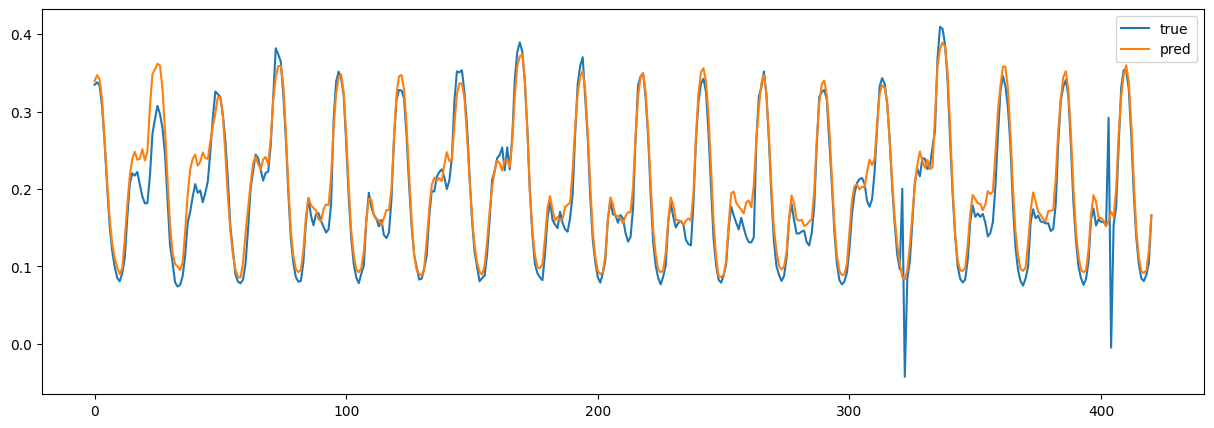

In [60]:
i=0
true = np.array(all_labels).reshape(-1,pred_length)
pred = np.array(all_predictions).reshape(-1,pred_length)
plt.figure(figsize=(15,5))
plt.plot(true.T[i], label='true')
plt.plot(pred.T[i], label='pred')
plt.legend()
plt.show()